In [1]:
import tensorflow as tf

2023-01-17 19:19:41.959326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 19:19:42.088904: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-17 19:19:42.088924: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-17 19:19:42.690567: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-01-17 19:20:14.912480: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 19:20:19.333726: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-17 19:20:19.333775: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aspire
2023-01-17 19:20:19.333781: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aspire
2023-01-17 19:20:19.333975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.60.11
2023-01-17 19:20:19.334001: I tensorflow/compiler/xla/stream_executor/c

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7582555858532963735
 xla_global_id: -1]

In [4]:
tf.random.set_seed(999)
np.random.seed(999)

In [5]:
!wget 'cdn.daitan.com/dataset.zip'

--2023-01-17 19:20:26--  http://cdn.daitan.com/dataset.zip
Resolving cdn.daitan.com (cdn.daitan.com)... failed: Name or service not known.
wget: unable to resolve host address ‘cdn.daitan.com’


In [6]:
dataset_file_name = './dataset.zip'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall('./dataset')

FileNotFoundError: [Errno 2] No such file or directory: './dataset.zip'

In [7]:
path_to_dataset = "../../data/clarity_CEC2_data/clarity_data/dev/scenes/"

In [15]:
# get training and validation tf record file names
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, '*_mix_CH1*'))[:100]


val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, '*_target_CH1*'))[:100]

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)


Training file names:  ['../../data/clarity_CEC2_data/clarity_data/dev/scenes/S06429_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S08042_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07966_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S08129_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07290_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S06957_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07866_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07190_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S06156_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S06587_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07734_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S08345_mix_CH1.wav', '../../data/clarity_CEC2_data/clarity_data/dev/scenes/S07103_mix_CH1.wav', '.

In [9]:
windowLength = 256
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength
inputFs      = 48e3
fs           = 16e3
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 16000.0
numFeatures: 129
numSegments: 8


In [10]:
mozilla_basepath = path_to_dataset
UrbanSound8K_basepath = path_to_dataset

## Prepare Input features

In [11]:
def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

## Create tf.Data.Dataset

In [55]:
from data_processing.mozilla_common_voice import MozillaCommonVoiceDataset
from data_processing.urban_sound_8K import UrbanSound8K
from data_processing.dataset import Dataset
import warnings

warnings.filterwarnings(action='ignore')

windowLength = 256
config = {'windowLength': windowLength,
          'overlap': round(0.25 * windowLength),
          'fs': 16000,
          'audio_max_duration': 0.8}

train_dataset = Dataset(train_tfrecords_filenames, **config)
train_dataset.create_tf_record(prefix='train', subset_size=100)

# train_dataset = Dataset(train_tfrecords_filenames, val_tfrecords_filenames, **config)
# train_dataset.create_tf_record(prefix='train', subset_size=4000)

# ## Create Test Set
# clean_test_filenames = mcv.get_test_filenames()

# noise_test_filenames = us8K.get_test_filenames()

test_dataset = Dataset(val_tfrecords_filenames, **config)
test_dataset.create_tf_record(prefix='test', subset_size=100, parallel=False)


TypeError: Dataset.__init__() missing 1 required positional argument: 'noise_filenames'

In [18]:
train_dataset = tf.data.TFRecordDataset(['./records/train_0.tfrecords'])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:

print(test_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 129, 8, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 129, 1, 1), dtype=tf.float32, name=None))>


## Model Training

In [20]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras import Model, Sequential

In [21]:
def conv_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(0.0006))(x)
  x = Activation('relu')(x)
  if use_bn:
    x = BatchNormalization()(x)
  return x

In [22]:
def full_pre_activation_block(x, filters, kernel_size, strides, padding='same', use_bn=True):
  shortcut = x
  in_channels = x.shape[-1]

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(x)

  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(filters=in_channels, kernel_size=kernel_size, strides=strides, padding='same')(x)

  return shortcut + x

In [23]:
def build_model(l2_strength):
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----
  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # -----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip1 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip1)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip1
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = Conv2D(filters=18, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
             kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = x + skip0
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(filters=8, kernel_size=[9,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [24]:
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 129, 8, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 137, 8, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 129, 1, 18)   1296        ['zero_padding2d[0][0]']         
                                                                                                  
 activation (Activation)        (None, 129, 1, 18)   0           ['conv2d[0][0]']                 
                                                                                              

                                                                                                  
 batch_normalization_10 (BatchN  (None, 129, 1, 30)  120         ['activation_10[0][0]']          
 ormalization)                                                                                    
                                                                                                  
 conv2d_11 (Conv2D)             (None, 129, 1, 8)    2160        ['batch_normalization_10[0][0]'] 
                                                                                                  
 activation_11 (Activation)     (None, 129, 1, 8)    0           ['conv2d_11[0][0]']              
                                                                                                  
 batch_normalization_11 (BatchN  (None, 129, 1, 8)   32          ['activation_11[0][0]']          
 ormalization)                                                                                    
          

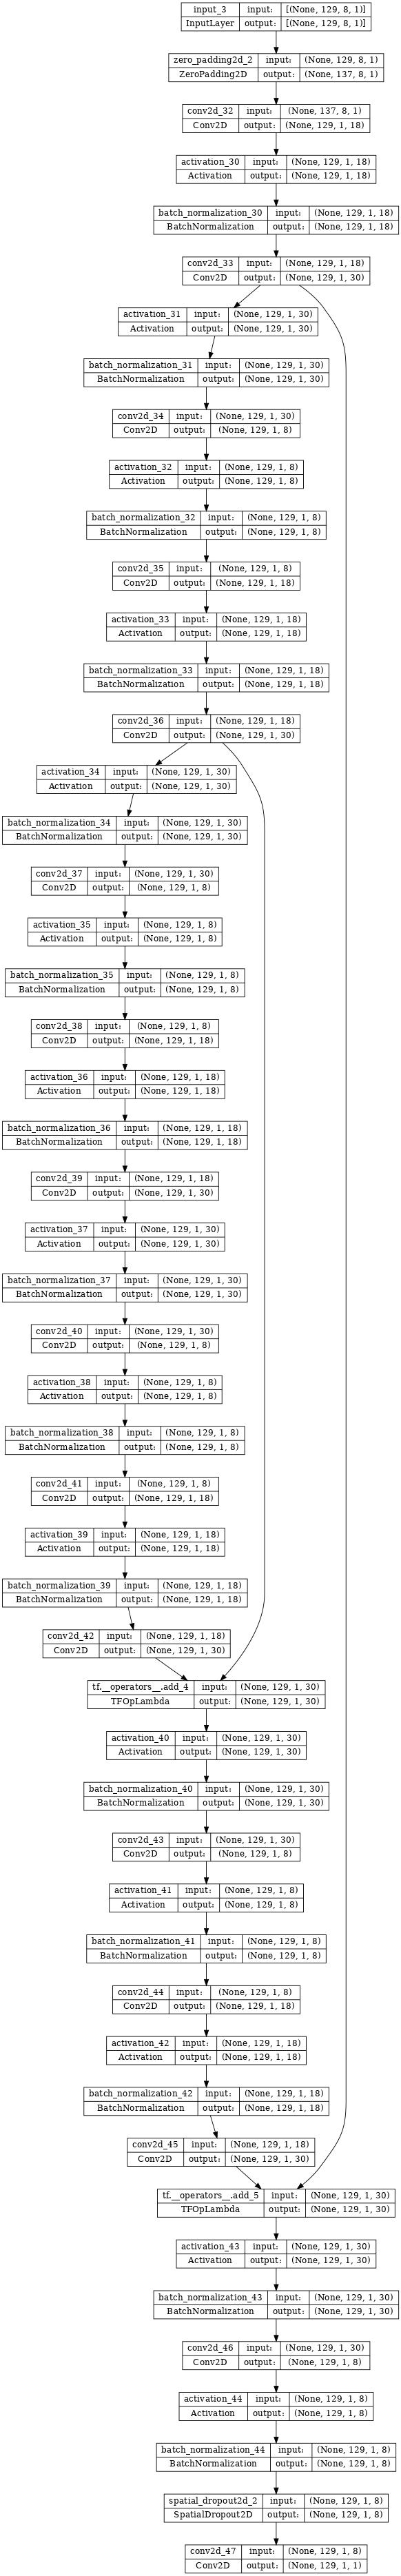

In [59]:
# You might need to install the following dependencies: sudo apt install python-pydot python-pydot-ng graphviz
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [21]:
%tensorboard --logdir logs

In [25]:
baseline_val_loss = model.evaluate(test_dataset)
print(f"Baseline accuracy {baseline_val_loss}")

40/40 [==============================] - 4s 80ms/step - loss: 0.5697 - rmse: 0.7548
Baseline accuracy [0.5696859955787659, 0.7547754049301147]


In [26]:
def l2_norm(vector):
    return np.square(vector)

def SDR(denoised, cleaned, eps=1e-7): # Signal to Distortion Ratio
    a = l2_norm(denoised)
    b = l2_norm(denoised - cleaned)
    a_b = a / b
    return np.mean(10 * np.log10(a_b + eps))

In [29]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=6, # you might need to change this
         validation_data=test_dataset,
         epochs=4,
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/4
6/6 [==============================] - 6s 1s/step - loss: 0.3949 - rmse: 0.6284 - val_loss: 0.3758 - val_rmse: 0.6130
Epoch 2/4
6/6 [==============================] - 6s 1s/step - loss: 0.3861 - rmse: 0.6214 - val_loss: 0.3707 - val_rmse: 0.6089
Epoch 3/4
6/6 [==============================] - 6s 1s/step - loss: 0.3777 - rmse: 0.6145 - val_loss: 0.3698 - val_rmse: 0.6081
Epoch 4/4
6/6 [==============================] - 5s 1s/step - loss: 0.3732 - rmse: 0.6109 - val_loss: 0.3707 - val_rmse: 0.6089


In [33]:
val_loss = model.evaluate(test_dataset)[0]
print(val_loss, baseline_val_loss)
if val_loss < baseline_val_loss[0]:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

40/40 [==============================] - 3s 80ms/step - loss: 0.3707 - rmse: 0.6089
0.37070995569229126 [0.5696859955787659, 0.7547754049301147]
New model saved.


## Testing

In [34]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))  # load a local WAV file

In [35]:
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [40]:
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'S08105_target_CH1.wav'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr) # load a local WAV file

Min: -0.14700295 Max: 0.33333334


In [41]:
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'S08105_mix_CH1.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) # load a local WAV file

Min: -0.3333333 Max: 0.30723047


In [42]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

Min: 0.0 Max: 5.167427


In [57]:
noisyAudio = noiseAudio
print(len(noisyAudio))
ipd.Audio(data=noisyAudio, rate=fs) # load a local WAV file

80091


In [47]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [48]:
noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# Paper: Besides, spectral phase was not used in the training phase.
# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.
noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

(129, 1252)


In [49]:
predictors = prepare_input_features(noise_stft_features)

In [50]:
predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

predictors.shape: (1252, 129, 8, 1)


In [51]:
STFTFullyConvolutional = model.predict(predictors)
print(STFTFullyConvolutional.shape)

40/40 [==============================] - 1s 8ms/step
(1252, 129, 1, 1)


In [52]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [53]:
denoisedAudioFullyConvolutional = revert_features_to_audio(STFTFullyConvolutional, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudioFullyConvolutional),"Max:",np.max(denoisedAudioFullyConvolutional))
ipd.Audio(data=denoisedAudioFullyConvolutional, rate=fs) # load a local WAV file

Min: -0.08067313 Max: 0.08045316


In [ ]:
# A numeric identifier of the sound class -- Types of noise
# 0 = air_conditioner
# 1 = car_horn
# 2 = children_playing
# 3 = dog_bark
# 4 = drilling
# 5 = engine_idling
# 6 = gun_shot
# 7 = jackhammer
# 8 = siren
# 9 = street_music

Text(0.5, 1.0, 'Denoised Audio')

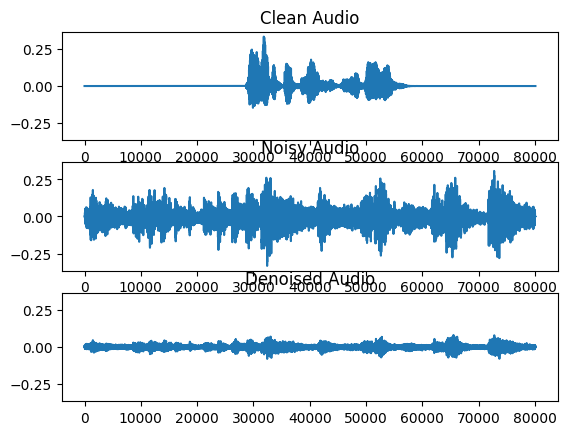

In [54]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True)

ax1.plot(cleanAudio)
ax1.set_title("Clean Audio")

ax2.plot(noisyAudio)
ax2.set_title("Noisy Audio")

ax3.plot(denoisedAudioFullyConvolutional)
ax3.set_title("Denoised Audio")